# Face Landmark Detection

#### Define different scripting flags in order to control training in a more simplified way

In [1]:
seed = 1233340 # Maybe change

DISABLE_TQDM = True # Disables progress bar in the whole notebook.

# Names of different neural networks architectures
MODEL_NAMES = ["LapaResNet18", "LapaMobileNetV2", "LapaEfficientNetB0", "LapaMobileNetV3Large", 
               "LapaMobileViT",
               "LapaMobileNetV3LargeFreeze", "LapaMobileNetV3LargeNotPretrained"]
# Fix one architecture to train
MODEL_NAME = "LapaEfficientNetB0"

def MODEL_CONSTRUCTOR(): # Will create model by its name
    return globals()[MODEL_NAME]()

# Suffixes controls different modifications in general learning algorithm of training.
MODEL_SUFFIXES = [
    None, # no modification 
    "wing", # use WingLoss instead of MSELoss
    "noaugs", # no Rotation and ColorJitter augs
    "noaugsnobboxaugs",  # noaugs + no random bounding box translation
    "nowarmup", # no Warmup for learning rate will be applied
    "withaugsonlydetector" # during training bbox will be produced always with detector
]
# Fix one modification to train
MODEL_SUFFIX = None

# These flags are changed according to specified MODEL_SUFFIX, do not change them manually
NO_AUGS = False
NO_BBOX_AUGS = False
ONLY_DETECTOR = False
NO_WARMUP = False
IS_WING_LOSS = False
if MODEL_SUFFIX:
    if "wing" in MODEL_SUFFIX:
        IS_WING_LOSS = True
    elif "noaugs" in MODEL_SUFFIX:
        NO_AUGS = True
    elif "nobboxaugs" in MODEL_SUFFIX:
        NO_BBOX_AUGS = True
    elif "nowarmup" in MODEL_SUFFIX:
        NO_WARMUP = True
    elif "onlydetector" in MODEL_SUFFIX:
        ONLY_DETECTOR = True
if "NotPretrained" in MODEL_NAME:
    NO_WARMUP = True

print(f"DISABLE_TQDM {DISABLE_TQDM}, MODEL_NAME {MODEL_NAME}, MODEL_SUFFIX {MODEL_SUFFIX}, NO_AUGS {NO_AUGS}, NO_BBOX_AUGS {NO_BBOX_AUGS}, ONLY_DETECTOR {ONLY_DETECTOR}, NO_WARMUP {NO_WARMUP}, IS_WING_LOSS {IS_WING_LOSS}")

DISABLE_TQDM True, MODEL_NAME LapaMobileViT, MODEL_SUFFIX None, NO_AUGS False, NO_BBOX_AUGS False, ONLY_DETECTOR False, NO_WARMUP False, IS_WING_LOSS False


#### Install dependencies

In [57]:
!pip install menpo --quiet # many usefull functions to work with images and annotated landmarks, https://www.menpo.org/
!pip install imutils --quiet
!pip install torch --upgrade --quiet # For old versions of env
!pip install torchvision --upgrade --quiet # For old versions of env
!pip install dlib --quiet # For new version of env

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
sns.set(palette="Set2", font_scale=1.3)

from tqdm import tqdm, trange
from functools import partial
tqdm = partial(tqdm, position=0, leave=True) # always will be updating existing progress bar, not printing new one
trange = partial(trange, position=0, leave=True)

import os
import cv2
from IPython.display import clear_output
from collections import defaultdict
import random
import time
from math import *
import itertools

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr
import torchvision.transforms.functional as TF
from torchvision import models
from torch import nn

import menpo
import menpo.io as mio
from menpo.shape import PointCloud

import dlib
from imutils import face_utils

In [58]:
# We will be using simple dlib detector to detect bounding box with the face
FACE_DETECTOR = dlib.get_frontal_face_detector()

#### Fix random states to provide determinated results

In [5]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

#### We will be using [LaPa](https://github.com/JDAI-CV/lapa-dataset) (Landmark guided face Parsing) dataset. 
LaPa dataset contains 22176 images of various faces, where each face is labeled with 106 landmarks. The original dataset was processed in order to be compaitable with the format which menpo requires.

In [6]:
dataset_dir = '/kaggle/input/lapa-prepared/LaPa/'
train_dataset_dir = os.path.join(dataset_dir, 'train', 'images_landmarks')
val_dataset_dir = os.path.join(dataset_dir, 'val', 'images_landmarks')
test_dataset_dir = os.path.join(dataset_dir, 'test', 'images_landmarks')

## Data Preparation

We will mostly consider pre-trained neural networks on the ImageNet challenge. Therefore, we apply the standard actions for the image preprocessing: translating pixel values into the range $[0, 1]$, scaling the image to the size of $224 \times 224$, normalizing the image.

The key points of the face after scaling the image can have coordinates $[0, 224)$, unless the face is completely placed on the image, which is almost always true. It is easier for neural networks to learn to predict small values, which are also symmetric with respect to zero. Therefore, for each key point $P$, we will apply the transformation $(P − (112, 112)) / 112$, which in most cases will translate the value of the coordinates of the point $P$ into the range $[-1, 1]$. 

One more useful notation is that it's better to pass only a small area containing the face to the neural network instead of the whole image. To do this, it is necessary to select this area in the original image before all the other actions described above. There are two ways to do this:
1. Crop the face according to the true landmarks of the image.
2. Use some already trained face detector to get a bounding box.

Using the $1$st method instead of the $2$nd would lead to better metric results on test data, but worse results on data outside our dataset. This is due to the fact that if we tried to apply our model to some image outside of our dataset, we would still have to get a bounding box using face detector. And often face detectors, especially quite simple and fast ones, do not generate the best quality frame. If a convolutional neural network will always learn from ideal bounding frames, then after seeing the frame received from the detector, it will not be able to produce a qualitative
result, because convolutions are not invariant to various shifts. This disadvantage of the first method can be smoothed to some extent
by augmenting the bounding box. 

Anyway, the $1$st method is a classic example of how the information about the target data can leak to the training stage. However, using it together with the $2$nd method at the training stage can help speed up and improve the quality of training. As a result, in the learning process, in order to obtain bounding box, we will randomly (uniformly) choose the $1$st or the $2$nd method. At the validation and testing stage, we will
use only the second method. 

We will also increase the resulting bounding box by $10\%$ on each of the axes. This is necessary in order not to lose some part of the face during its detection or during the subsequent augmentation of the bounding box.

#### Used augmentations:
1. Random rotation of the image (by an angle up to $35^{\circ}$).
2. Color manipulation: changing the brightness, contrast, saturation and hue of the image.
3. A random shift of the borders of the bounding box.

In [61]:
def get_shape_distance_from_box(shape_center, box):
    x, y = shape_center
    x_b, y_b = (box[0][0] + box[1][0]) / 2, (box[0][1] + box[1][1]) / 2 
    return ((x - x_b)**2 + (y - y_b)**2)**0.5

def rect_to_menpo_box_bounds(rect):
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    return [np.array([y, x]), np.array([y + h, x + w])]

def menpo_box_bounds_to_rect(box):
    x = box[0][1]
    y = box[0][0]
    h = box[1][0] - box[0][0]
    w = box[1][1] - box[0][1]
    return x, y, w, h

def get_bounding_box(img, face_detector=FACE_DETECTOR):
    shape = img.landmarks['PTS']
    shape_center = shape.centre()
    boxes = face_detector(np.asarray(img.as_PILImage()))
    
    min_shape_distance = None
    best_box = None
    for box in boxes:
        box = rect_to_menpo_box_bounds(box)
        dist = get_shape_distance_from_box(shape_center, box)
        if min_shape_distance is None or dist < min_shape_distance: 
            min_shape_distance = dist
            best_box = box
    return best_box if best_box is not None else shape.bounding_box().bounds()

def move_box_border(border, dim_range, dim_range_proportion):
    '''
    Example: have box [y1, x1], [y2, x2], dim_range_proportion=0.1.
    Border y1 may move to 5% up or 5% down with uniform probability, where % are measured according to (y2 - y1).
    '''
    return border + dim_range * dim_range_proportion * (random.random() - 0.5)

def move_box_borders(box, dim_range_proportion):
    box[0][0] = move_box_border(box[0][0], box[1][0] - box[0][0], dim_range_proportion)
    box[1][0] = move_box_border(box[1][0], box[1][0] - box[0][0], dim_range_proportion)
    box[0][1] = move_box_border(box[0][1], box[1][1] - box[0][1], dim_range_proportion)
    box[1][1] = move_box_border(box[1][1], box[1][1] - box[0][1], dim_range_proportion)
    return box

def increase_box(box, part):
    '''
    part=0.3 => 0.15 of height and width will be added for each side of the box.
    '''
    h = box[1][0] - box[0][0]
    box[1][0] = box[1][0] + part * h / 2 
    box[0][0] = box[0][0] - part * h / 2 
    w = box[1][1] - box[0][1]
    box[1][1] = box[1][1] + part * w / 2 
    box[0][1] = box[0][1] - part * w / 2

def detector_or_landmarks_crop(img, is_train, detector_train_prob=0.5, move_borders_proportion=0.3, increase_box_part=0.1):
    if ONLY_DETECTOR or (not is_train) or random.random() <= detector_train_prob:
        box = get_bounding_box(img)
    else:
        box = img.landmarks['PTS'].bounding_box().bounds()
    
    if (not NO_BBOX_AUGS) and is_train:
        box = move_box_borders(box, move_borders_proportion)
        
    increase_box(box, increase_box_part)
        
    return img.crop(
        min_indices=(box[0][0], box[0][1]),
        max_indices=(box[1][0], box[1][1]),
        constrain_to_boundary=True # not to go beyond real boundaries
    )

In [8]:
def get_centered_landmarks(points):
    return (points - 112) / 112

def prepare_image_and_landmarks(img, is_train):
    '''
    Accepts image in [0, 1] range.
    If is_train=True applies crop augmentation.
    '''
    img = detector_or_landmarks_crop(img, is_train)
    img = img.resize((224, 224))
    pixels = torch.tensor(img.pixels, dtype=torch.float32)
    
    if not img.has_landmarks:
        raise RuntimeError('No landmarks for image')
    landmarks = get_centered_landmarks(img.landmarks['PTS'].points.reshape(-1))
    landmarks = torch.tensor(landmarks, dtype=torch.float32)
                    
    return pixels, landmarks

In [9]:
class RandomRotate(torch.nn.Module):
    def __init__(self, degrees, p=0.5):
        super(RandomRotate, self).__init__()
        self.degrees = degrees
        self.p = p
        
    def forward(self, data):
        img, landmarks = data[0], data[1]
        if random.random() <= self.p:
            angle = random.randint(-self.degrees, self.degrees)
            
            img = TF.rotate(img, -angle)
            
            transformation_matrix = torch.tensor([
                [+cos(radians(angle)), -sin(radians(angle))], 
                [+sin(radians(angle)), +cos(radians(angle))]
            ])
            landmarks = np.matmul(landmarks.reshape(106, 2), transformation_matrix).reshape(-1)
        return img, landmarks

class WithNoLandmarkTransform(torch.nn.Module):
    def __init__(self, image_transform):
        super(WithNoLandmarkTransform, self).__init__()
        self.image_transform = image_transform
        
    def forward(self, data):
        img, landmarks = data[0], data[1]
        return self.image_transform(img), landmarks

In [10]:
class LapaDataset(Dataset):
    def __init__(self, img_dir, is_train):
        super(LapaDataset).__init__()
        
        self.is_train = is_train
        self.paths = [os.path.join(img_dir, file) 
                      for file in os.listdir(img_dir) 
                      if file.endswith(".jpg")]
        self.normalize = tr.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            
        if self.is_train:
            self.additional_augmentations = tr.Compose([
                RandomRotate(degrees=35),
                WithNoLandmarkTransform(tr.ColorJitter(
                    brightness=0.25, contrast=0.15, saturation=0.3, hue=0.1
                )),
            ])
            
    def __getitem__(self, index):
        img = mio.import_image(self.paths[index])
        pixels, landmarks = prepare_image_and_landmarks(img, self.is_train)
        if (not NO_AUGS) and self.is_train:
            pixels, landmarks = self.additional_augmentations((pixels, landmarks))
        pixels = self.normalize(pixels)
        return pixels, landmarks
    
    def __len__(self):
        return len(self.paths)

In [11]:
ds_train = LapaDataset(train_dataset_dir, is_train=True)
ds_val = LapaDataset(val_dataset_dir, is_train=False)

#### Visualizing the preprocessed images:

Train raw images: 


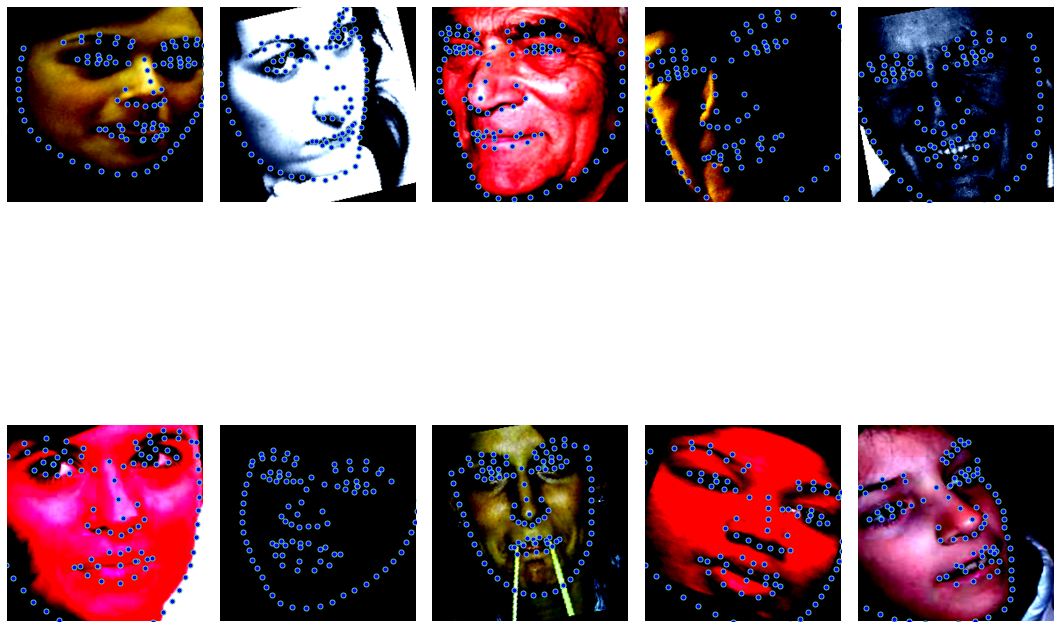

In [12]:
h, w = 2, 5
fig, ax = plt.subplots(h, w, figsize=(20, 15))

print("Train raw images: ")
for i in range(h * w):
    plt.subplot(h, w, i+1)
    
    pixels, landmarks = ds_train[i]
    landmarks = PointCloud(112 * landmarks.reshape(106, 2) + 112)
    img = menpo.image.base.Image(pixels)
    img.landmarks['PTS'] = landmarks
    img.view_landmarks(group='PTS', render_markers=True, marker_face_colour='b', figure_size=(15, 15))
    
    if i + 1 >= h * w:
        break
fig.tight_layout()
plt.show()

Val raw images: 


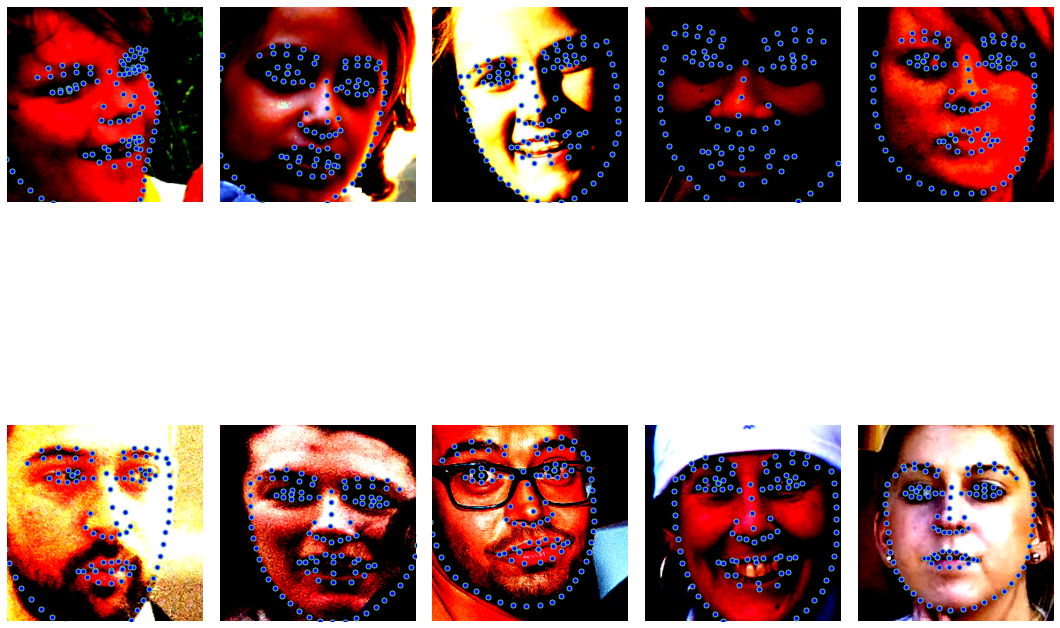

In [13]:
h, w = 2, 5
fig, ax = plt.subplots(h, w, figsize=(20, 15))

print("Val raw images: ")
for i in range(h * w):
    plt.subplot(h, w, i+1)
    
    pixels, landmarks = ds_val[i]
    landmarks = PointCloud(112 * landmarks.reshape(106, 2) + 112)
    img = menpo.image.base.Image(pixels)
    img.landmarks['PTS'] = landmarks
    img.view_landmarks(group='PTS', render_markers=True, marker_face_colour='b', figure_size=(15, 15))
    
    if i + 1 >= h * w:
        break
fig.tight_layout()
plt.show()

#### Selecting device, batch_size and setup dataloaders

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [15]:
batch_size = 16
num_workers = 4 if device == torch.device('cpu') else 2

In [16]:
dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    num_workers=num_workers, 
    generator=g
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    worker_init_fn=seed_worker,
    num_workers=num_workers, 
    generator=g
)

torch.float32
torch.float32


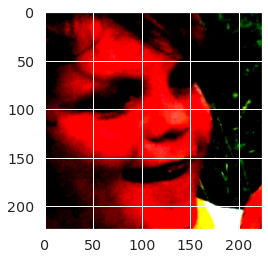

In [17]:
img_batch, landmarks_batch = next(iter(dataloader_val))
print(img_batch[0].dtype)
print(landmarks_batch[0].dtype)
plt.imshow(img_batch[0].numpy().transpose(1, 2, 0))
plt.show()

#### The code below can be used to calculate model parameters

In [18]:
from termcolor import colored

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

# Считаем общее число параметров в нашей модели
def model_num_params(model, verbose_total=False, verbose_all=False, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        param[0],
                        beautiful_int(num_params),
                        param[1].requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
        sum_params += num_params
        if param[1].requires_grad:
            sum_learnable_params += num_params
    
    if verbose_total:
        print(f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params')
    return beautiful_int(sum_params), beautiful_int(sum_learnable_params)

#### Defining different neural networks architectures that will be considered: ResNet18, MobileNetV2, EfficientNetB0, MobileNetV3-Large, MobileViT-Small

In [19]:
class LapaResNet18(nn.Module):
    def __init__(self):
        super(LapaResNet18, self).__init__()
        
        self.network = models.resnet18(weights='DEFAULT')
        self.network.fc = nn.Linear(512, 106*2)

    def forward(self, imgs):
        return self.network(imgs)

In [20]:
class LapaMobileNetV2(nn.Module):
    def __init__(self):
        super(LapaMobileNetV2, self).__init__()
        
        self.network = models.mobilenet_v2(weights='DEFAULT')
        self.network.classifier[-1] = nn.Linear(1280, 106*2)

    def forward(self, imgs):
        return self.network(imgs)

In [21]:
class LapaEfficientNetB0(nn.Module):
    def __init__(self):
        super(LapaEfficientNetB0, self).__init__()
        
        self.network = models.efficientnet_b0(weights='DEFAULT')
        self.network.classifier[-1] = nn.Linear(1280, 106*2)

    def forward(self, imgs):
        return self.network(imgs)

In [22]:
class LapaMobileNetV3Large(nn.Module):
    def __init__(self):
        super(LapaMobileNetV3Large, self).__init__()
        
        self.network = models.mobilenet_v3_large(weights='DEFAULT')
        self.network.classifier[-1] = nn.Linear(1280, 106*2)

    def forward(self, imgs):
        return self.network(imgs)

In [ ]:
# from transformers import AutoFeatureExtractor, AutoModelForImageClassification

# class LapaMobileViT(nn.Module):
#     def __init__(self):
#         super(LapaMobileViT, self).__init__()
        
#         self.network = AutoModelForImageClassification.from_pretrained("apple/mobilevit-small")
#         self.network.classifier = nn.Linear(640, 106*2)

#     def forward(self, imgs):
#         return self.network(imgs[:, [2, 1, 0]]).logits

#### LapaMobileNetV3LargeFreeze is LapaMobileNetV3-Large with 3/16 freezeed layers

In [23]:
class LapaMobileNetV3LargeFreeze(nn.Module):
    def __init__(self):
        super(LapaMobileNetV3LargeFreeze, self).__init__()
        
        self.network = models.mobilenet_v3_large(weights='DEFAULT')
        
        for param in itertools.chain(
            self.network.features[0].parameters(),
            self.network.features[1].parameters(),
            self.network.features[2].parameters(),
        ):
            param.requires_grad = False
        self.network.classifier[-1] = nn.Linear(1280, 106*2)

    def forward(self, imgs):
        return self.network(imgs)

#### LapaMobileNetV3LargeNotPretrained is LapaMobileNetV3-Large with randomly initialized weights

In [24]:
class LapaMobileNetV3LargeNotPretrained(nn.Module):
    def __init__(self):
        super(LapaMobileNetV3LargeNotPretrained, self).__init__()
        
        self.network = models.mobilenet_v3_large()
        self.network.classifier[-1] = nn.Linear(1280, 106*2)

    def forward(self, imgs):
        return self.network(imgs)

#### Define training and validation phaze, learing loop

In [26]:
def train(model, optimizer, loader, criterion):
    model.train()
    
    losses_tr = []
    for img_batch, landmarks_batch in tqdm(loader, disable=DISABLE_TQDM):
        img_batch = img_batch.to(device)
        landmarks_batch = landmarks_batch.to(device) 
                
        pred = model(img_batch)
        loss = criterion(pred, landmarks_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
        
    return model, optimizer, np.mean(losses_tr)


@torch.no_grad()
def val(model, loader, criterion, scheduler=None, metric_names=None):
    model.eval()
    
    losses_val = []
    if metric_names:
        metrics = defaultdict(list)
        
    for img_batch, landmarks_batch in tqdm(loader, disable=DISABLE_TQDM):
        img_batch = img_batch.to(device)
        landmarks_batch = landmarks_batch.to(device) 

        pred = model(img_batch)
        loss = criterion(pred, landmarks_batch)
        
        losses_val.append(loss.item())
        
        if metric_names:
            if 'NME' in metric_names:
                shapes = landmarks_batch.reshape(-1, 106, 2).cpu()
                target_shapes = pred.reshape(-1, 106, 2).cpu()
                eye_dists = np.linalg.norm(target_shapes[:, 105, :] - target_shapes[:, 104, :], axis=1)
                error = np.mean(np.linalg.norm(shapes - target_shapes, axis=2).mean(axis=1) / eye_dists)
                metrics['NME'].append(error)

    loss = np.mean(losses_val)
    
    if scheduler:
        try:
            scheduler.step()
        except:
            scheduler.step(loss)
            
    if metric_names:
        for name in metrics:
            metrics[name] = np.mean(metrics[name])
    
    return loss, metrics if metric_names else None

In [27]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    epochs,
    curr_epoch=0,
    losses={'train': [], 'val': []},
    lrs = [],
    metrics_NMEs = [],
    scheduler=None,
    min_lr=None,
    separate_show=False,
    model_name=MODEL_NAME,
    chkp_folder="/kaggle/working/chkp",
    metric_names=None,
):
    if not os.path.exists(chkp_folder):
        os.makedirs(chkp_folder)
        
    best_val_loss = np.Inf if len(losses['val']) == 0 else min(losses['val'])
    if metric_names:
        metrics = defaultdict(list)
        metrics['NME'] = metrics_NMEs

    for epoch in range(curr_epoch+1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)
        print(f'Train loss: {loss}')

        loss, metrics_ = val(model, val_loader, criterion, scheduler, metric_names=metric_names)
        losses['val'].append(loss)
        print(f'Val loss: {loss}')

        if metrics_:
            for name, value in metrics_.items():
                metrics[name].append(value)
                print(f'Metric {name}: {value}')

        # SAVE
        if loss <= best_val_loss:
            os.system(f'rm -rf {chkp_folder}/*')
            save_name = f'{model_name}_best.pt'
            best_val_loss = loss
        else:
            os.system(f'rm -rf {chkp_folder}/*_last.pt')
            save_name = f'{model_name}_last.pt'
        torch.save(
            {
                'epoch': epoch,
                'model_name': model_name,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'losses': losses,
                'lrs': lrs,
                'NMEs': metrics['NME'],
            },
            os.path.join(chkp_folder, save_name),
        )

        # DRAW
        clear_output(True)
        ww = 3 if separate_show else 2
        ww_metrics = 0
        if metric_names:
            plot_ids_ = [
                [key, metric_meta.get("plot id", 1)]
                for key, metric_meta
                in metric_names.items()
            ]
            ww_metrics = len(set(el[1] for el in plot_ids_))
            assert all(el[1] <= ww_metrics for el in plot_ids_)

            plot_ids = defaultdict(list)
            for el in plot_ids_:
                plot_ids[el[1]].append(el[0])

        fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
        fig.suptitle(f'#{epoch}/{epochs}:')

        plt.subplot(1, ww + ww_metrics, 1)
        plt.plot(losses['train'], 'r.-', label='train')
        if separate_show:
            plt.title('loss on train')
            plt.legend()
        plt.grid()

        if separate_show:
            plt.subplot(1, ww + ww_metrics, 2)
            plt.title('loss on validation')
            plt.grid()
        else:
            plt.title('losses')
        plt.plot(losses['val'], 'g.-', label='val')
        plt.legend()

        plt.subplot(1, ww + ww_metrics, ww)
        plt.title('learning rate')
        plt.plot(lrs, 'g.-', label='lr')
        plt.legend()
        plt.grid()

        if metric_names:
            for plot_id, keys in plot_ids.items():
                for key in keys:
                    plt.subplot(1, ww + ww_metrics, ww + plot_id)
                    plt.title(f'additional metrics #{plot_id}')
                    for name in metrics:
                        if key in name:
                            plt.plot(metrics[name], '.-', label=name)
                    plt.legend()
                    plt.grid()

        plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
        
    return model, optimizer, losses

We will use __Adam__ optimizer. The learning step will decrease by $4$ times if the validation loss function does not improve after $4$ epochs. However, __Warmup__ will be used for the first $3$ epochs: the initial step will increase linearly from the value $10^{-5}$ to $10^{-3}$. This technique helps the optimizer to get used to the data and not to update the weights aggressively at the first epochs. This is necessary in order not to break the good weights of the pre-trained neural network. We also will try to train without Warmup and even without pretraining. Later on we will see that the results in these cases are worse. 

On the next image you can see the example of how learing rate changes during training:

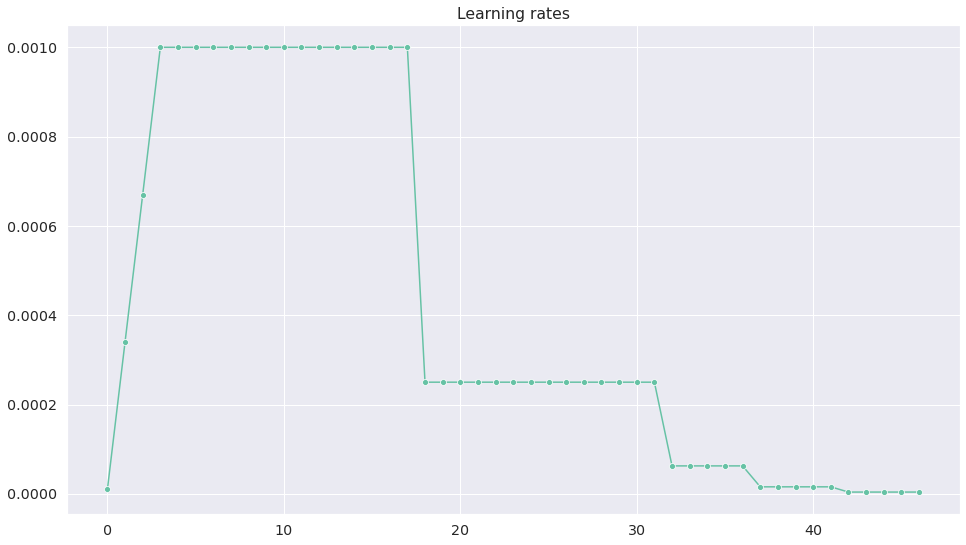

In [64]:
lrs = torch.load("/kaggle/input/coursework-data/LapaResNet18_last.pt", map_location=device)['lrs']

rcParams['figure.figsize'] = 16, 9
g = sns.lineplot(x=range(len(lrs)), y=lrs, marker="o", label="Train Loss")
g.set_title('Learning rates')
plt.grid() 
plt.grid() 
plt.legend([],[], frameon=False)
plt.savefig("lrs.pdf", bbox_inches = 'tight')
plt.show()

In [28]:
class WarmupScheduler:
    def __init__(self, scheduler, lr_start, epochs):
        self.scheduler = scheduler
        self.curr_step = 0
        self.epochs = epochs
        
        self.lr_add = (get_lr(self.scheduler.optimizer) - lr_start) / self.epochs
        for p in self.scheduler.optimizer.param_groups:
            p['lr'] = lr_start
    
    def state_dict(self):
        return {key: (value if key != 'scheduler' else value.state_dict()) for key, value in self.__dict__.items()}
    
    def load_state_dict(self, state_dict):
        self.scheduler.load_state_dict(state_dict['scheduler'])
        del state_dict['scheduler']
        self.__dict__.update(state_dict) 
        
    # some schdulers should take loss value, some not
    def step(self, loss=None):
        self.curr_step += 1
        if self.curr_step <= self.epochs:
            for p in self.scheduler.optimizer.param_groups:
                p['lr'] += self.lr_add
        else:
            try:
                self.scheduler.step()
            except:
                self.scheduler.step(loss)

In [29]:
def create_env():
    model = MODEL_CONSTRUCTOR().float().to(device)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3, [0.99, 0.999])
    if NO_WARMUP:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)
    else:
        scheduler = WarmupScheduler(
            scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True),
            lr_start=1e-5,
            epochs=3
        )
    model_name = MODEL_NAME
    if MODEL_SUFFIX:
        model_name = f"{model_name}_{MODEL_SUFFIX}"
    return model, optimizer, scheduler, model_name

__MSE__ loss function is not resistant to outliers. So, it's likely that due to the strong influence of such outliers, the neural network cannot learn the necessary patterns in the data well enough. The quality of training can be greatly improved by using the __Wing__ loss function.

In [30]:
class WingLoss(nn.Module):
    def __init__(self, eps=3, w=15):
        super(WingLoss, self).__init__()
        self.eps = eps
        self.w = w
        self.C = w - w * np.log(1 + w / eps)

    def forward(self, output, target):
        abs_diff = torch.abs(output - target)
        losses = torch.where(
            abs_diff < self.w,
            self.w * torch.log(1 + abs_diff / self.eps),
            abs_diff - self.C
        )
        loss = torch.mean(losses)
        return loss

The comparison of __Wing__ and __MSE__ losses

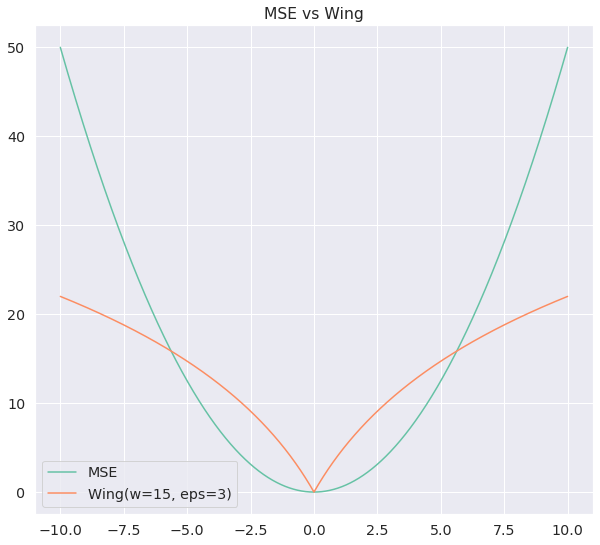

In [31]:
x = torch.arange(-10, 10, 0.001)

mse = x**2 / 2

w, eps = 15, 3
wing = torch.where(
    torch.abs(x) < w,
    w * torch.log(1 + torch.abs(x) / eps),
    torch.abs(x) - w - w * np.log(1 + w / eps)
)

rcParams['figure.figsize'] = 10, 9
g = sns.lineplot(x=x, y=mse, label="MSE")
g = sns.lineplot(x=x, y=wing, label="Wing(w=15, eps=3)")
g.set_title('MSE vs Wing')
plt.savefig("mse_vs_wing.pdf", bbox_inches='tight')
plt.show()

#### Training

In [66]:
model, optimizer, scheduler, model_name = create_env()
criterion = WingLoss() if IS_WING_LOSS else nn.MSELoss()

base_name = f"/kaggle/input/coursework-data/{model_name}"
model_folder = f"{base_name}_last.pt" if os.path.exists(f"{base_name}_last.pt") else f"{base_name}_best.pt"

if os.path.exists(model_folder): # take existing model and continue training
    checkpoint = torch.load(model_folder, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    lrs = checkpoint['lrs']
    metrics_NMEs = checkpoint['NMEs']
else: # training from scratch
    epoch=0,
    losses={'train': [], 'val': []},
    lrs = [],
    metrics_NMEs = [],

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    epochs = 150,
    curr_epoch=epoch,
    losses=losses,
    lrs=lrs,
    metrics_NMEs=metrics_NMEs,
    scheduler = scheduler,
    min_lr = 1e-6,
    separate_show = False,
    model_name = model_name,
    metric_names = {
        'NME': {'plot_id': 1}
    }
)

We trained a bunch of models which can be divided into 3 groups:
1. Main architectures: ResNet18, MobileNetV2, EfficientNetB0, MobileNetV3-Large, MobileViT-Small. All trained with Warmup, described augmentations, MSE loss.
2. Different modifications of MobileNetV3-Large: 
    - withaugsonlydetector. The bounding box is selected always with the help of detector
    - Freeze. The first 3 out of 16 layers of MobileNetV3-Large are freezed.
    - noaugs. No rotation and color jitter augmentations.
    - noaugsnobboxaugs. Previous one + no bounding box translation augmentation.
    - nowarmup. Warmup is not used.
    - NotPretrained. Weights are initialized randomly, warmup is also not used.
3. EfficientNetB0, as the most accurate from the 1st group, and MobileNetV3-Large as, in theory, the fastest in terms of inference time, architectures trained with the Wing loss function instead of MSE.

In [33]:
model_names = [
    'LapaResNet18',
    'LapaMobileNetV2',
    'LapaEfficientNetB0',
    'LapaMobileNetV3Large',
    'LapaMobileViT',

    'LapaMobileNetV3Large_withaugsonlydetector',
    'LapaMobileNetV3LargeFreeze',
    'LapaMobileNetV3Large_noaugs',
    'LapaMobileNetV3Large_noaugsnobboxaugs',
    'LapaMobileNetV3Large_nowarmup',
    'LapaMobileNetV3LargeNotPretrained',
    
    'LapaMobileNetV3Large_wing',
    'LapaEfficientNetB0_wing',
]

def load_model(model_name):
    base_name = f"/kaggle/input/coursework-data/{model_name}"
    model_folder = f"{base_name}_last.pt" if os.path.exists(f"{base_name}_last.pt") else f"{base_name}_best.pt"
    checkpoint = torch.load(model_folder, map_location=device)

    model_class_name = model_name.split('_')[0]
    model = globals()[model_class_name]().float().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    lrs = checkpoint['lrs']
    metrics_NMEs = checkpoint['NMEs']
    
    return model, epoch, losses, lrs, metrics_NMEs

### Visualizing the predictions on test part of the dataset (blue - true, yellow - predicted)

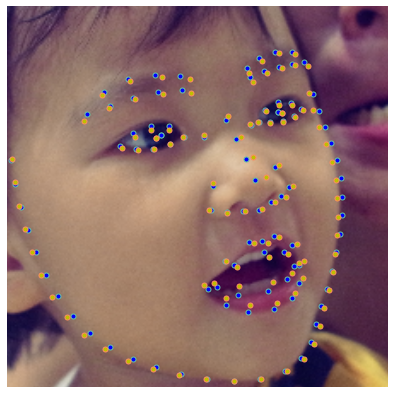

In [76]:
def view_landnmarks(img_path):
    img = mio.import_image(img_path)
    
    # Change this part, if image prepare is changed
    img = detector_or_landmarks_crop(img, is_train=False)
    img = img.resize((224, 224))
    pixels = torch.FloatTensor(img.pixels)
    pixels = ds_test.normalize(pixels)
    #
    pixels_batch = pixels[None].to(device)
    
    landmarks = model(pixels_batch)[0].reshape(106, 2).detach().cpu().numpy()
    landmarks = PointCloud(112 * landmarks + 112)
    img.landmarks['predicted'] = landmarks

    img.view_landmarks(group='PTS', render_markers=True, marker_face_colour='b')
    img.view_landmarks(group='predicted', render_markers=True, marker_face_colour='y')


model, _, _, _, _ = load_model("LapaEfficientNetB0_wing")
view_landnmarks('/kaggle/input/lapa-prepared/LaPa/test/images_landmarks/10001868414_0.jpg')

### Visualizing the training stage of different models

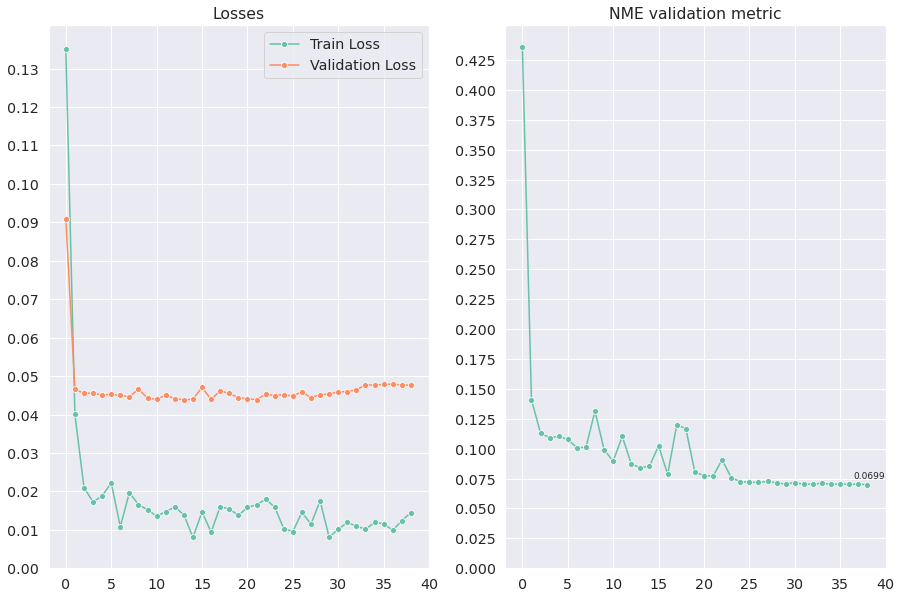

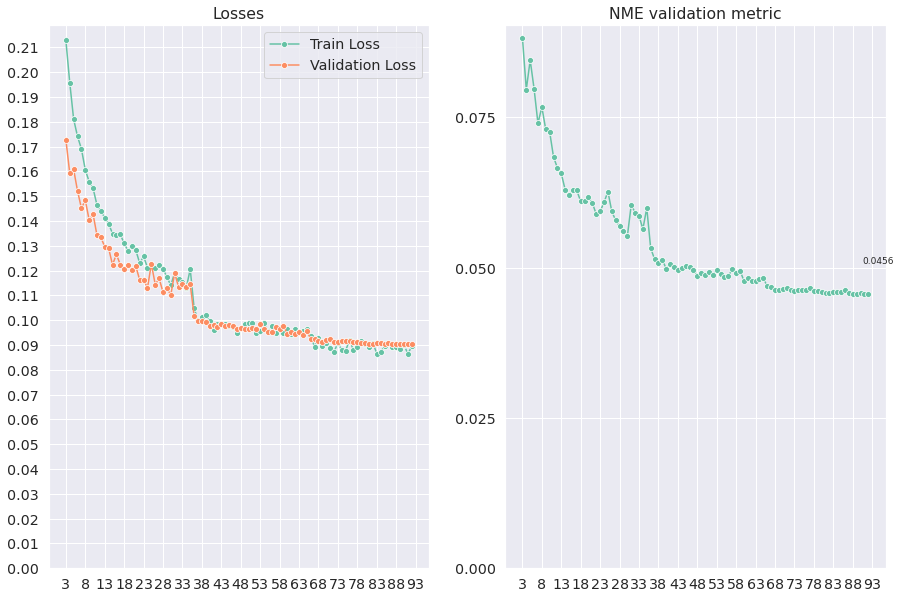

In [72]:
def draw_learning_plots(losses, metric, start, save_name=None):    
    losses['train'] = losses['train'][start:]
    losses['val'] = losses['val'][start:]
    metric = metric[start:]

    x = [start + i for i in range(len(losses['train']))]

    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    sns.lineplot(ax=axes[0], x=x, y=losses['train'], marker="o", label="Train Loss")
    sns.lineplot(ax=axes[0], x=x, y=losses['val'], marker="o", label="Validation Loss")
    axes[0].set_title('Losses')
    axes[0].set_yticks(np.arange(0, max(max(losses['train']), max(losses['val'])), 0.01))
#     axes[0].set_yticks([0.005, 0.05, 1.35])
    axes[0].set_xticks(range(start, start + len(metric) + 5, 5))
    axes[0].legend()
    plt.grid()

    sns.lineplot(ax=axes[1], x=x, y=metric, marker="o")
    axes[1].set_title('NME validation metric')
    axes[1].set_yticks(np.arange(0, max(metric), 0.025))
    axes[1].set_xticks(range(start, start + len(metric) + 5, 5))
    axes[1].annotate(f"{metric[-1]:.4f}", (x[-1]-1.5, metric[-1]+0.005), fontsize=9)
    plt.grid()

    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight')
    plt.show()

def load_and_plot(model_name, start_epoch=0, save_name=None):
    _, _, losses, _, metrics_NMEs = load_model(model_name)
    draw_learning_plots(losses, metrics_NMEs, start_epoch, save_name)


load_and_plot("LapaEfficientNetB0", start_epoch=0)
load_and_plot("LapaEfficientNetB0_wing", start_epoch=3)

### The code below helps to measure NME metric on test part of dataset, CPU inference time and GPU inference time.

In [36]:
ds_test = LapaDataset(test_dataset_dir, is_train=False)

dataloader_test = DataLoader(
    dataset=ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    worker_init_fn=seed_worker,
    num_workers=num_workers, 
    generator=g
)

@torch.no_grad()
def test(model, loader, metric_names=None):
    model.eval()
    
    if metric_names:
        metrics = defaultdict(list)
        
    for img_batch, landmarks_batch in tqdm(loader, disable=DISABLE_TQDM):
        img_batch = img_batch.to(device)
        landmarks_batch = landmarks_batch.to(device) 

        pred = model(img_batch)
        
        if metric_names:
            if 'NME' in metric_names:
                shapes = landmarks_batch.reshape(-1, 106, 2).cpu()
                target_shapes = pred.reshape(-1, 106, 2).cpu()
                eye_dists = np.linalg.norm(target_shapes[:, 105, :] - target_shapes[:, 104, :], axis=1)
                error = np.mean(np.linalg.norm(shapes - target_shapes, axis=2).mean(axis=1) / eye_dists)
                metrics['NME'].append(error)

    if metric_names:
        for name in metrics:
            metrics[name] = np.mean(metrics[name])
    
    return metrics if metric_names else None

@torch.no_grad()
def test_time(model, dataset, n=10):
    model.eval()

    times = []
    for i in trange(n, disable=DISABLE_TQDM):
        if i >= len(dataset):
            break
            
        img, landmarks = dataset[i]
        img_batch = img[None].to(device)
        
        start = time.time()
        pred = model(img_batch)
        end = time.time()
        
        times.append(end - start)
        
    times = np.array(times)
    times = times * 1000
    return times

# https://deci.ai/blog/measure-inference-time-deep-neural-networks/
@torch.no_grad()
def gpu_test_time(model, dataset, n=300):
    model.eval()
    
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    #GPU-WARM-UP
    dummy_input = torch.randn(1, 3, 224, 224, dtype=torch.float).to(device)
    for _ in range(100):
        _ = model(dummy_input)

    times = []
    for i in trange(n, disable=DISABLE_TQDM):
        if i >= len(dataset):
            break
            
        img, landmarks = dataset[i]
        img_batch = img[None].to(device)
        
        starter.record()
        pred = model(img_batch)
        ender.record()
        
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        times.append(curr_time)
        
    times = np.array(times)
    return times

#### Get type of CPU and GPU.

In [73]:
!lscpu |grep 'Model name'
!nvidia-smi -L

Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
/bin/bash: nvidia-smi: command not found


#### Measure NME metric, training epochs and inference time on CPU.

In [ ]:
def test_model(model_name):
    model, epoch, _, _, _ = load_model(model_name)
    NME_metric = test(model, dataloader_test, metric_names={'NME'})['NME']
    times = test_time(model, ds_test, len(ds_test))
    return epoch, NME_metric, times

for model_name in tqdm(model_names, disable=DISABLE_TQDM):
    epochs, NME, times = test_model(model_name)
    df.loc[model_name, 'epochs'] = epochs
    df.loc[model_name, 'inference_mean_ms'] = np.mean(times)
    df.loc[model_name, 'inference_std_ms'] = np.std(times)
    df.loc[model_name, 'NME'] = NME
df.to_csv('stats_df.csv')

#### Measure inference time on GPU.

In [56]:
for model_name in tqdm(model_names, disable=DISABLE_TQDM):
    model, epoch, _, _, _ = load_model(model_name)
    times = gpu_test_time(model, ds_test, len(ds_test))
    df.loc[model_name, 'GPU_inference_mean_ms'] = np.mean(times)
    df.loc[model_name, 'GPU_inference_std_ms'] = np.std(times)
df.to_csv('stats_df.csv')

### The final table with models statistics:

In [75]:
df = pd.read_csv("/kaggle/input/coursework-data/stats_df.csv", index_col=0)
df

,epochs,inference_mean_ms,inference_std_ms,NME,GPU_inference_mean_ms,GPU_inference_std_ms,params_count_M,GFLOPS
LapaResNet18,47.0,52.520241,8.228409,0.078430,4.015335,0.599006,11.7,1.81
LapaMobileNetV2,50.0,28.790338,3.399825,0.077333,7.389791,1.796852,3.5,0.30
LapaEfficientNetB0,39.0,40.911371,4.987302,0.073668,11.290291,1.984964,5.3,0.39
LapaMobileNetV3Large,32.0,25.633413,2.801100,0.078775,8.465799,1.105382,5.5,0.22
LapaMobileNetV3Large_withaugsonlydetector,40.0,25.633413,2.801100,0.088409,8.465799,1.105382,5.5,0.22
LapaMobileNetV3LargeFreeze,39.0,25.633413,2.801100,0.081652,8.465799,1.105382,5.5,0.22
LapaMobileNetV3Large_noaugs,40.0,25.633413,2.801100,0.082262,8.465799,1.105382,5.5,0.22
LapaMobileNetV3Large_noaugsnobboxaugs,33.0,25.633413,2.801100,0.093106,8.465799,1.105382,5.5,0.22
LapaMobileNetV3Large_nowarmup,39.0,25.633413,2.801100,0.080675,8.465799,1.105382,5.5,0.22
LapaMobileNetV3LargeNotPretrained,56.0,25.633413,2.801100,0.088055,8.465799,1.105382,5.5,0.22


### The dependence of the NME metric on various parameters: the inference time on the CPU, on the GPU, GFLOPS, the number of learnable parameters

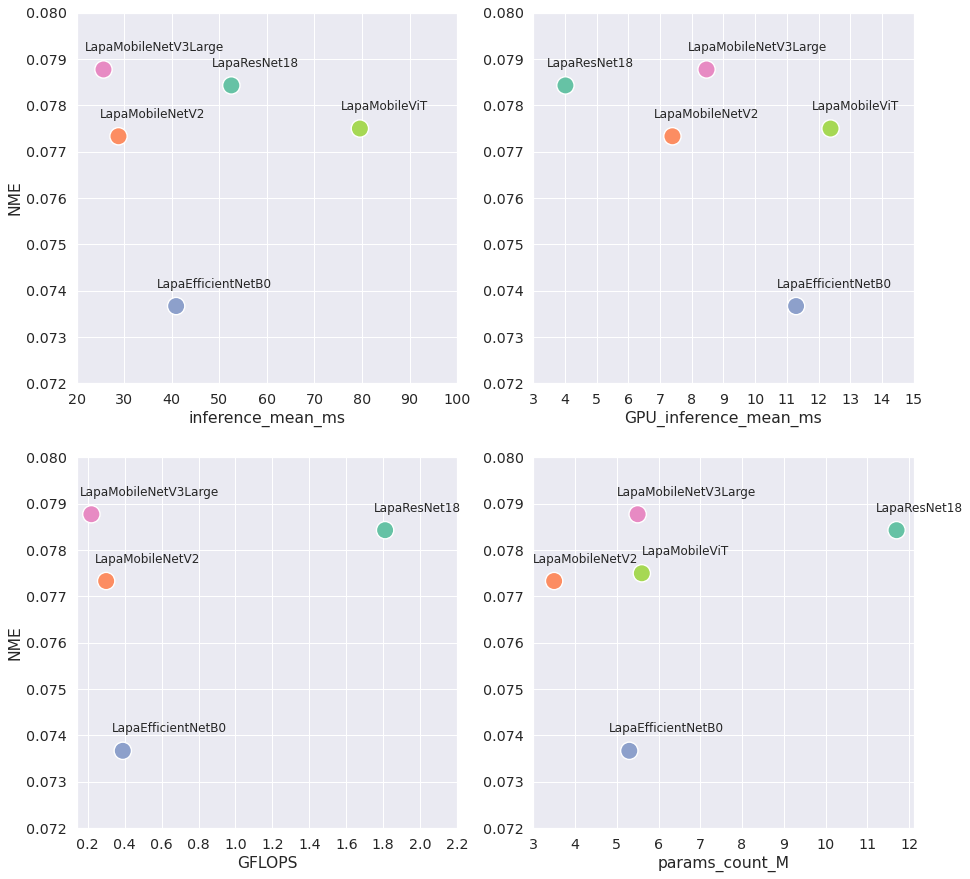

In [50]:
df_archs = df.loc[["LapaResNet18", "LapaMobileNetV2", "LapaEfficientNetB0", "LapaMobileNetV3Large", "LapaMobileViT"]]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

g = sns.scatterplot(ax=axes[0, 0], data=df_archs, x="inference_mean_ms", y="NME", hue=df_archs.index, marker="o", s=300)
g.set_yticks(np.arange(0.072, 0.080, 0.001))
g.set_xticks(range(20, 101, 10))
g.legend([],[], frameon=False)
for name in df_archs.index:
    g.annotate(f"{name}", (df_archs.loc[name]['inference_mean_ms'] - 4, df_archs.loc[name]['NME'] + 4e-4), fontsize=12)
    
g = sns.scatterplot(ax=axes[0, 1], data=df_archs, x="GPU_inference_mean_ms", y="NME", hue=df_archs.index, marker="o", s=300)
g.set_yticks(np.arange(0.072, 0.080, 0.001))
g.set_xticks(range(3, 16, 1))
g.legend([],[], frameon=False)
g.set_ylabel('')
for name in df_archs.index:
    g.annotate(f"{name}", (df_archs.loc[name]['GPU_inference_mean_ms'] - 0.6, df_archs.loc[name]['NME'] + 4e-4), fontsize=12)
    
g = sns.scatterplot(ax=axes[1, 0], data=df_archs, x="GFLOPS", y="NME", hue=df_archs.index, marker="o", s=300)
g.set_yticks(np.arange(0.072, 0.080, 0.001))
g.set_xticks(np.arange(0.2, 2.3, 0.2))
g.legend([],[], frameon=False)
for name in df_archs.index:
    g.annotate(f"{name}", (df_archs.loc[name]['GFLOPS'] - 0.06, df_archs.loc[name]['NME'] + 4e-4), fontsize=12)
    
    
g = sns.scatterplot(ax=axes[1, 1], data=df_archs, x="params_count_M", y="NME", hue=df_archs.index, marker="o", s=300)
g.set_yticks(np.arange(0.072, 0.080, 0.001))
g.set_xticks(np.arange(3, 13, 1))
g.legend([],[], frameon=False)
g.set_ylabel('')
for name in df_archs.index:
    x_offset = -0.5
    if name == "LapaMobileViT":
        x_offset = 0
    g.annotate(f"{name}", (df_archs.loc[name]['params_count_M'] + x_offset, df_archs.loc[name]['NME'] + 4e-4), fontsize=12)
    
plt.savefig("NME_from_other_params.pdf", bbox_inches = 'tight')
plt.show()

There is an ambiguous picture on the plots. Firstly, all architectures, except EfficientNetB0, gave approximately the same metric. However, it is very important, especially for practical purposes, how fast neural networks solve the problem. There are different indicators of effectiveness. 

For example, FLOPS is the number of floating–point operations performed by a neural network. However, FLOPS does not take into account such inference factors as the speed of memory access, the degree of parallelism and the characteristics of the platform. We also measured the inference time on the Intel(R) Xeon(R) CPU @ 2.20GHz and inference time on Tesla P100 (GPU). The plots show that, for example, ResNet18 has more than 8 times more FLOPS than MobileNetV3, however, the CPU inference time is only 2 times worse and the GPU inference time is even 2 times better. Such contradictory inference time of the ResNet18 relative to other architectures is explained by the fact that all the other architectures use Depthwise convolutions, which are implemented extremely ineffectively in PyTorch. Also, all other architectures are more optimized for mobile devices.

MobileViT is, as expected, slower than other architectures due to the presence of transformer components. Moreover, on mobile devices, the gap
is likely to increase even more, because convolutions are quite well optimized for mobile devices, which cannot be said about transformers.

### NME of LapaMobileNetV3-Large and its modifications

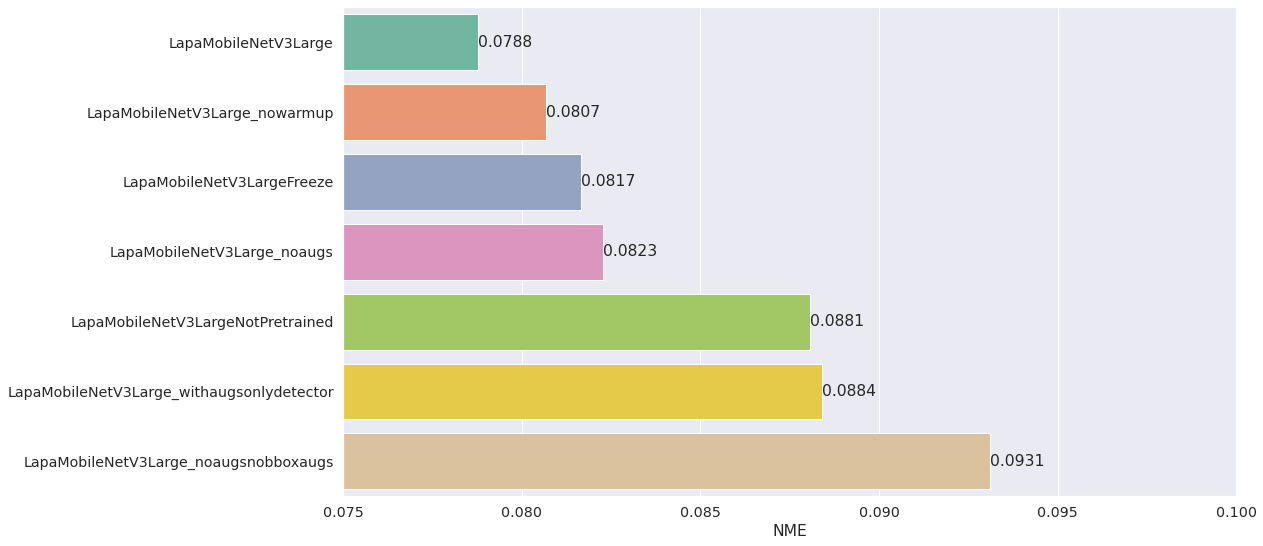

In [197]:
rcParams['figure.figsize'] = 16, 9

df_archs = df.loc[[
    "LapaMobileNetV3Large", 
    "LapaMobileNetV3Large_withaugsonlydetector", 
    "LapaMobileNetV3LargeFreeze", 
    "LapaMobileNetV3Large_noaugs",
    "LapaMobileNetV3Large_noaugsnobboxaugs", 
    "LapaMobileNetV3Large_nowarmup", 
    "LapaMobileNetV3LargeNotPretrained",
]]
df_bars = df_archs.copy()
df_bars.sort_values(['NME'], inplace=True)

g = sns.barplot(data=df_bars, x="NME", y=df_bars.index)
g.bar_label(g.containers[0], fmt='%.4f')
g.set(xlim=(0.075, 0.1))
plt.savefig("NME_mobilenetv3_and_modifications.pdf", bbox_inches = 'tight')

We see that all the modifications considered make the final quality of predictions worse. This confirms the importance of various considered aspects of neural network training.

### NME of main architectures

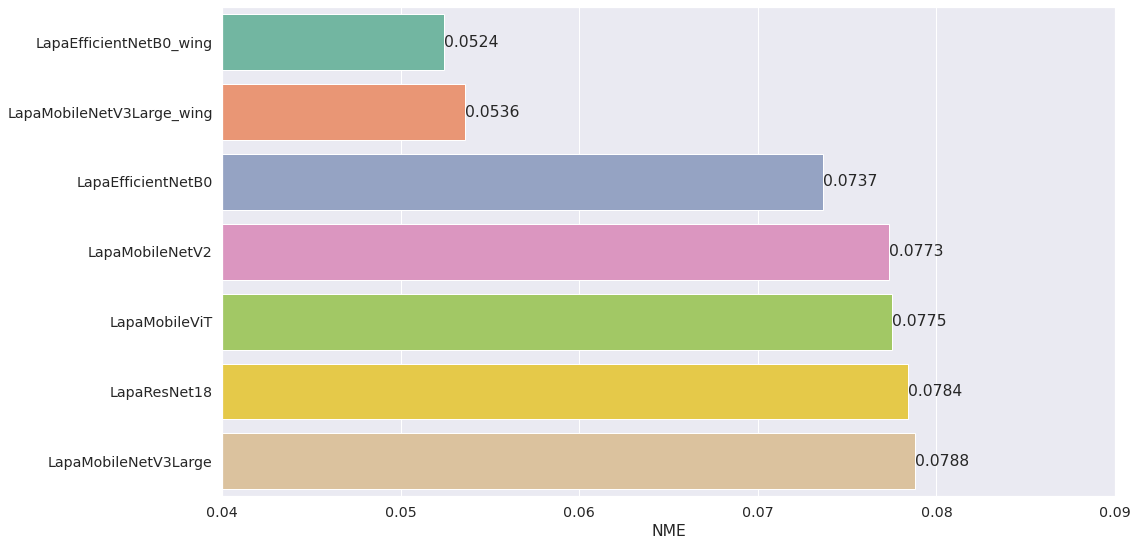

In [196]:
rcParams['figure.figsize'] = 16, 9

df_archs = df.loc[["LapaResNet18", "LapaMobileNetV2", "LapaEfficientNetB0", "LapaMobileNetV3Large", "LapaMobileViT", 
                   "LapaMobileNetV3Large_wing", "LapaEfficientNetB0_wing"]]
df_bars = df_archs.copy()
df_bars.sort_values(['NME'], inplace=True)

g = sns.barplot(data=df_bars, x="NME", y=df_bars.index)
g.bar_label(g.containers[0], fmt='%.4f')
g.set(xlim=(0.04, 0.09))
plt.savefig("NME_main_archs_and_wing.pdf", bbox_inches = 'tight')

Architectures trained with Wing loss provides much better results. EfficientNetB0 is likely to be the most precise type of architecture.

# Inference. Image outside of the dataset

In [99]:
def preprocess_image(image):
    image = TF.to_pil_image(image)
    image = TF.resize(image, (224, 224))
    image = TF.to_tensor(image) / 255
    image = ds_test.normalize(image)
    return image

def draw_landmarks_on_faces(image, faces_landmarks):
    image = image.copy()
    for landmarks, (left, top, height, width) in faces_landmarks:
        landmarks = (landmarks + 1) / 2
        landmarks = landmarks.view(-1, 2).numpy()
        for i, (y, x) in enumerate(landmarks, 1):
            try:
                cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 3, [40, 117, 255], -1)
            except:
                pass
    return image

def constrain_rect_to_img_boundaries(img, x, y, w, h):
    x = max(0, x)
    if x + w > img.shape[1]:
        w = img.shape[1] - x
    y = max(0, y)
    if y + h > img.shape[0]:
        h = img.shape[0] - y
    return x, y, w, h

@torch.no_grad()
def inference(frame, prev_faces=None):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = FACE_DETECTOR(gray, 1)
    
    # Sometimes detector can't recognize faces even in easy conditions. 
    # So we just use the previos bounding box in these cases.
    if len(faces) == 0 and prev_faces:
        faces = prev_faces

    outputs = []
    for (i, face) in enumerate(faces):
        box = rect_to_menpo_box_bounds(face)
        increase_box(box, 0.1) # CHECK THIS PARAM
        x, y, w, h = menpo_box_bounds_to_rect(box)
        
        x, y, w, h = constrain_rect_to_img_boundaries(frame, x, y, w, h)
        crop_img = frame[y: y + h, x: x + w]
        preprocessed_image = preprocess_image(crop_img)
        
        pixels_batch = preprocessed_image[None].to(device)
        landmarks = model(pixels_batch)[0].cpu()
        outputs.append((landmarks, (x, y, h, w)))
    return draw_landmarks_on_faces(frame, outputs), faces

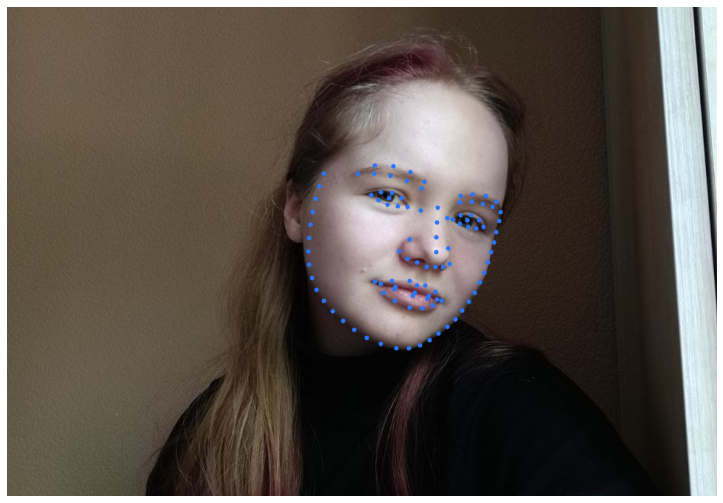

In [103]:
model, _, _, _, _ = load_model("LapaEfficientNetB0_wing")
img = cv2.imread('/kaggle/input/coursework-data/face_photo_example.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, _ = inference(img)
img = img[0:-200, :]

rcParams['figure.figsize'] = 16, 9
plt.axis('off')
plt.grid(visible=None)
plt.imshow(img)
plt.savefig("face_photo_example_processed.pdf", bbox_inches='tight')
# plt.savefig("face_photo_example_processed.png", bbox_inches='tight')

# Inference. Process the video

In [78]:
!pip install moviepy --quiet # to process and record new video

In [38]:
from moviepy.editor import VideoFileClip

In [40]:
video = VideoFileClip("/kaggle/input/coursework-data/face_video_example.mp4")
print('FPS:', video.fps)
print('Duration:', video.duration, 'seconds')

FPS: 30.0
Duration: 12.03 seconds


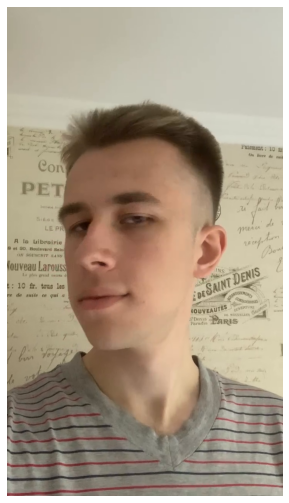

In [90]:
frames = list(video.iter_frames())
plt.axis('off')
plt.grid(visible=None)
plt.imshow(frames[120])

In [101]:
def output_video(video, name, seconds = None):
    total = int(video.fps * seconds) if seconds else int(video.fps * video.duration)
    writer = cv2.VideoWriter(name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), video.fps, tuple(video.size))
    
    faces = None
    outputs = []
    times = []
    for i, frame in enumerate(tqdm(video.iter_frames(), total=total), 1):    
        if seconds:
            if (i + 1) == total:
                break
                
        start = time.time()
        output, faces = inference(frame, faces)
        end = time.time()
        times.append(end - start)
        
        outputs.append(output)

        writer.write(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

    writer.release()
    
    times = np.array(times)
    times = times * 1000
    print(f'Inference Time: {times.mean()} +- {times.std()} ms')

    return outputs

361it [03:39,  1.64it/s]                         

Inference Time: 592.2255146206251 +- 16.162834005458095 ms


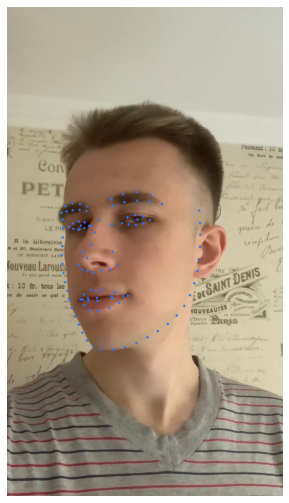

In [102]:
outputs = output_video(video, 'face_video_example_processed')

plt.axis('off')
plt.grid(visible=None)
plt.imshow(frames[120])
plt.imshow(outputs[120])